# Running Noisy Simulations on GPU

<span style="font-variant: small-caps;">Simphony</span> is a Python package designed for **simulating the spin dynamics** of point defects, in particular the nitrogen-vacancy (NV) center, which is surrounded by nuclear spins and serves as a **central-spin quantum register**.

In this tutorial, we show how to perform quantum simulations **in the presence of noise** and accelerate them **using a GPU**. We begin by simulating a simple $\text{RX}(\pi/2)$ pulse applied to an electron spin, followed by the simulation of a **Ramsey experiment**.

## Import the packages

First, import the required packages:

In [1]:
import numpy as np
np.set_printoptions(linewidth=200, precision=4) # to print wide matrices

import simphony
simphony.Config.set_platform('gpu')
simphony.Config.set_matplotlib_format('retina')

from qiskit import QuantumCircuit

from matplotlib import pyplot as plt
from scipy.stats import bootstrap
from scipy.optimize import curve_fit

We define a model that includes the electron spin and the $^{14}\text{N}$ nuclear spin in a static magnetic field of $50~\text{mT}$:

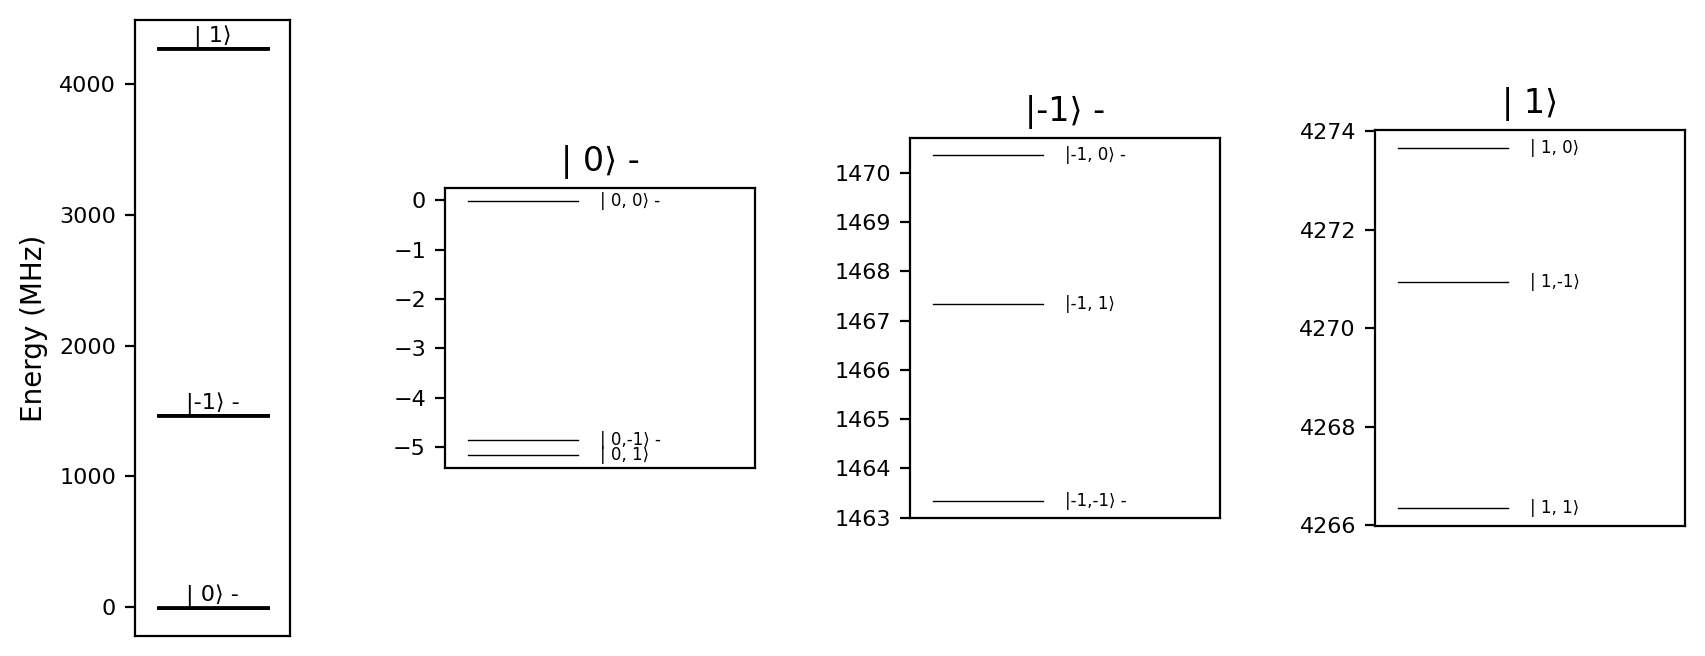

In [2]:
model = simphony.default_nv_model(nitrogen_isotope=14,
                                  static_field_strength=0.05)
model.plot_levels()

We apply a strong $\text{RX}(\pi/2)$ pulse to the electron spin. The pulse duration is chosen such that the Rabi frequency

$$
\Omega_R = \frac{1}{4 \times 0.01~\mu\text{s}} = 25~\text{MHz},
$$

is much larger than the hyperfine interaction (approximately $2~\text{MHz}$). The driving frequency is set to the average electron spin transition frequency corresponding to the `0` and `-1` nuclear spin states. These conditions ensure that the pulse acts as an **unconditional gate on the electron spin**, meaning its effect is independent of the nuclear spin state:

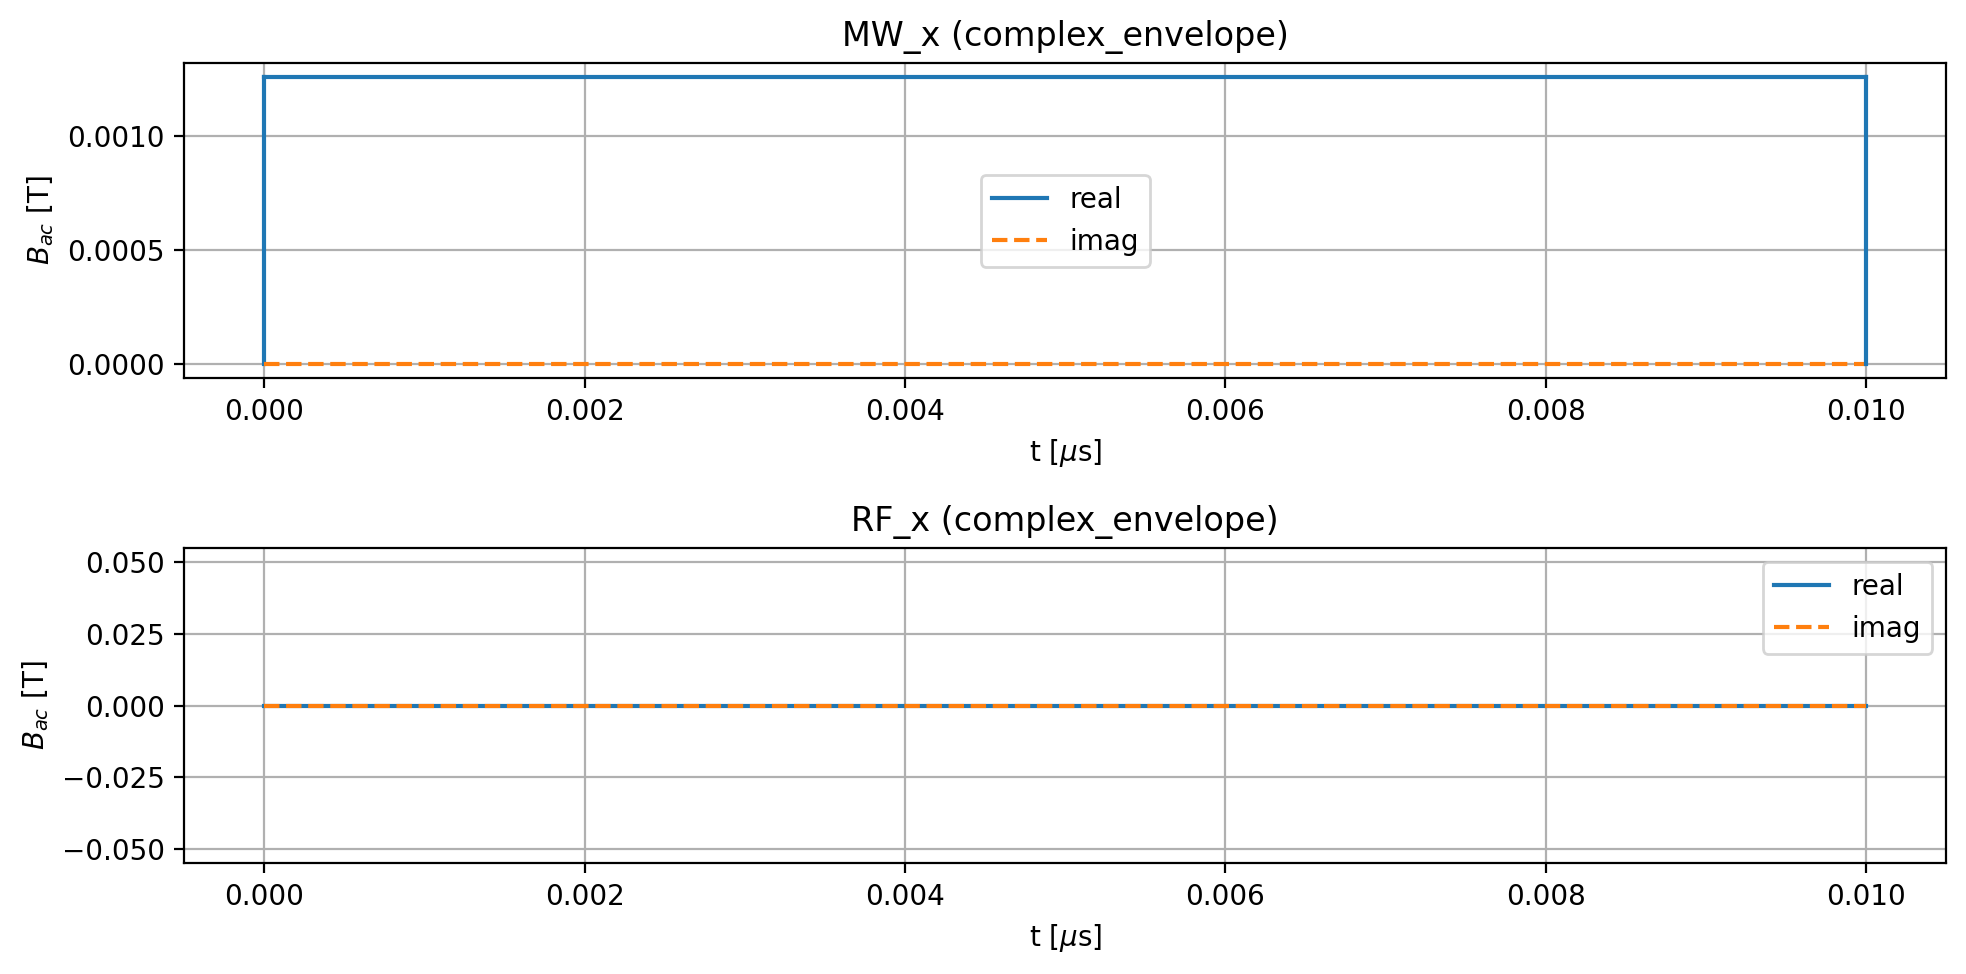

In [3]:
duration = 0.01
frequency = model.splitting_qubit('e')
phase = 0
angle = np.pi/2
period_time = 2 * np.pi * duration / angle
amplitude = model.rabi_cycle_amplitude_qubit(driving_field_name='MW_x',
                                             period_time=period_time,
                                             spin_name='e')

model.remove_all_pulses()
model.driving_field('MW_x').add_rectangle_pulse(amplitude=amplitude,
                                                frequency=frequency,
                                                phase=phase,
                                                duration=duration)


model.plot_driving_fields(function='complex_envelope')

Run a simulation:

In [4]:
result = model.simulate_time_evolution(verbose=True)

start = 0.0
end = 0.01
solver_method = jax_expm_parallel
number of simulated driving terms = 1
number of simulated noise terms = 0
---------------------------------------------------------------------------
simulate time segment [0.0000, 0.0100] with step size 2.722e-06 (type: single_sine_wave)


Next, we examine the dynamics of the Bloch vectors starting from an initial state. The applied rotation acts only on the electron spin around the x-axis, while the nuclear spin remains unaffected:

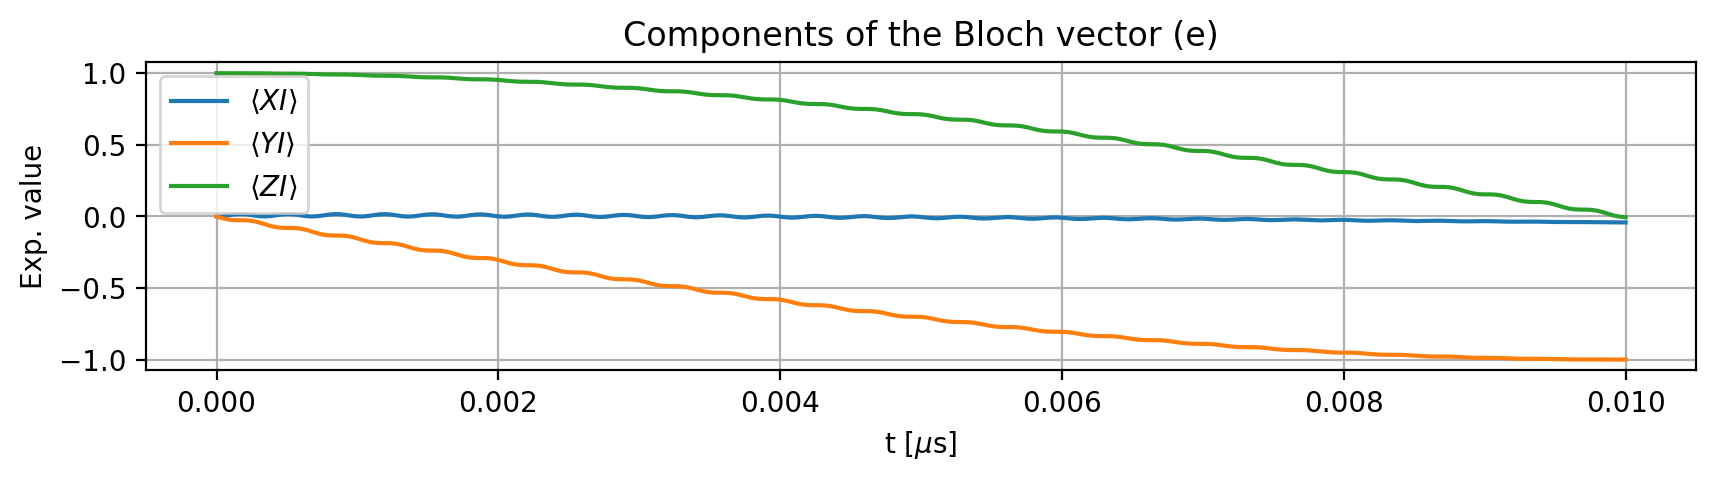

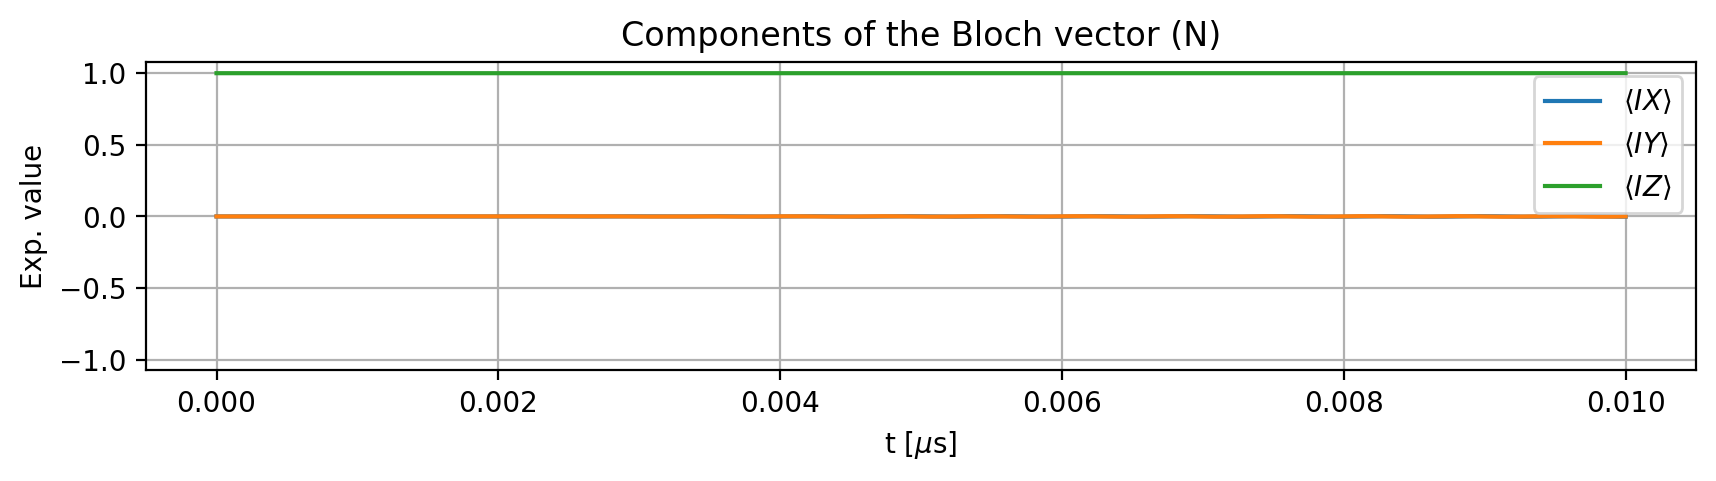

In [5]:
result.initial_state = model.productstate({'e': 0, 'N': 0})
result.plot_Bloch_vectors()

The ideal gate corresponds to an $\text{RX}(\pi/2)$ rotation on the electron spin:

In [6]:
qc = QuantumCircuit(2)
qc.rx(np.pi/2, 0)
qc.draw()

┌─────────┐
q_0: ┤ Rx(π/2) ├
     └─────────┘
q_1: ───────────

The applied pulse implements this gate with high fidelity:

In [7]:
result.ideal = qc
result.average_gate_fidelity()

np.float64(0.9982905313299243)

## Noisy simulations

Beyond noiseless simulations, <span style="font-variant: small-caps;">Simphony</span> also supports **time evolution in the presence of noise**. Currently, the so-called local **quasistatic noise model** is implemented in <span style="font-variant: small-caps;">Simphony</span>, which is an efficient method for simulating **dephasing** in spin systems. In this framework, **random local magnetic noise** is introduced, modeled as a normally distributed static field. The noise strength — defined as the standard deviation of the normal distribution, typically expressed in energy units — is related to the spin’s $T_2^*$ time.

To compute physical quantities under this noise model, one must **run multiple simulations with different, statistically independent noise realizations and average the results**. In <span style="font-variant: small-caps;">Simphony</span>, we **refer to these individual realizations as _shots_**. The term *local* indicates that the noise is **uncorrelated across different spins**.

Now, we add local quasistatic noise to both the electron and nuclear spins. Since the dominant contribution comes from the *z*-components of the random magnetic noise, we only assign finite values to the *z*-components. It is important to note that this noise has been artificially enhanced for demonstration purposes:

In [8]:
model.spin('e').local_quasistatic_noise.z = 10 # MHz
model.spin('N').local_quasistatic_noise.z = 0.001 # MHz

In this case, the noise Hamiltonian has the form:

$$ H_\text{noise} = \Delta E_{\text{e},z} S_z + \Delta E_{\text{n},z} I_z,$$

where $\Delta E_{\text{e},z}$ and $\Delta E_{\text{n},z}$ are the noise strengths (in $\text{MHz}$). Operators corresponding to the local quasistatic noise can be calculated by the `model.calculate_local_quasistatic_noise_operators()` method, but the deafult NV model automatically calculate it. The `local_quasistatic_noise_operators` attribute stores the operators as nested list of $[[S_x, S_y, S_z], [I_x, I_y, I_z]]$:

In [9]:
model.local_quasistatic_noise_operators

[[array([[0.    +0.j, 0.    +0.j, 0.    +0.j, 0.7071+0.j, 0.    +0.j, 0.    +0.j, 0.    +0.j, 0.    +0.j, 0.    +0.j],
         [0.    +0.j, 0.    +0.j, 0.    +0.j, 0.    +0.j, 0.7071+0.j, 0.    +0.j, 0.    +0.j, 0.    +0.j, 0.    +0.j],
         [0.    +0.j, 0.    +0.j, 0.    +0.j, 0.    +0.j, 0.    +0.j, 0.7071+0.j, 0.    +0.j, 0.    +0.j, 0.    +0.j],
         [0.7071+0.j, 0.    +0.j, 0.    +0.j, 0.    +0.j, 0.    +0.j, 0.    +0.j, 0.7071+0.j, 0.    +0.j, 0.    +0.j],
         [0.    +0.j, 0.7071+0.j, 0.    +0.j, 0.    +0.j, 0.    +0.j, 0.    +0.j, 0.    +0.j, 0.7071+0.j, 0.    +0.j],
         [0.    +0.j, 0.    +0.j, 0.7071+0.j, 0.    +0.j, 0.    +0.j, 0.    +0.j, 0.    +0.j, 0.    +0.j, 0.7071+0.j],
         [0.    +0.j, 0.    +0.j, 0.    +0.j, 0.7071+0.j, 0.    +0.j, 0.    +0.j, 0.    +0.j, 0.    +0.j, 0.    +0.j],
         [0.    +0.j, 0.    +0.j, 0.    +0.j, 0.    +0.j, 0.7071+0.j, 0.    +0.j, 0.    +0.j, 0.    +0.j, 0.    +0.j],
         [0.    +0.j, 0.    +0.j, 0.    +0.j, 0.

**Modification of the strengths** of the noise components of the spins **is possible before or after calculating the Hamiltonians**.

When running noisy simulations, the `n_shots` parameter plays a central role. It controls the **number of the independent noise realizations** used to simulate the time evolution. Setting a `random_seed` ensures reproducibility of random realizations in simulations:

In [10]:
result_noisy = model.simulate_time_evolution(n_shots=3, random_seed=42, verbose=True)

start = 0.0
end = 0.01
solver_method = jax_expm_parallel
number of simulated driving terms = 1
number of simulated noise terms = 2
---------------------------------------------------------------------------
simulate time segment [0.0000, 0.0100] with step size 2.722e-06 (type: single_sine_wave)


To plot expactation values, we have to add an initial state to the `result_noisy` object:

In [11]:
result_noisy.initial_state = model.productstate({'e': 0, 'N': 0})

When we run simulations with multiple shots, `shot` **argument** of the `expectation_value` and `plot_expectation_value` methods becomes relevant. It **could be** `'avg'` **or a specific shot** indicated by an integer.

The three shots of the simulation:

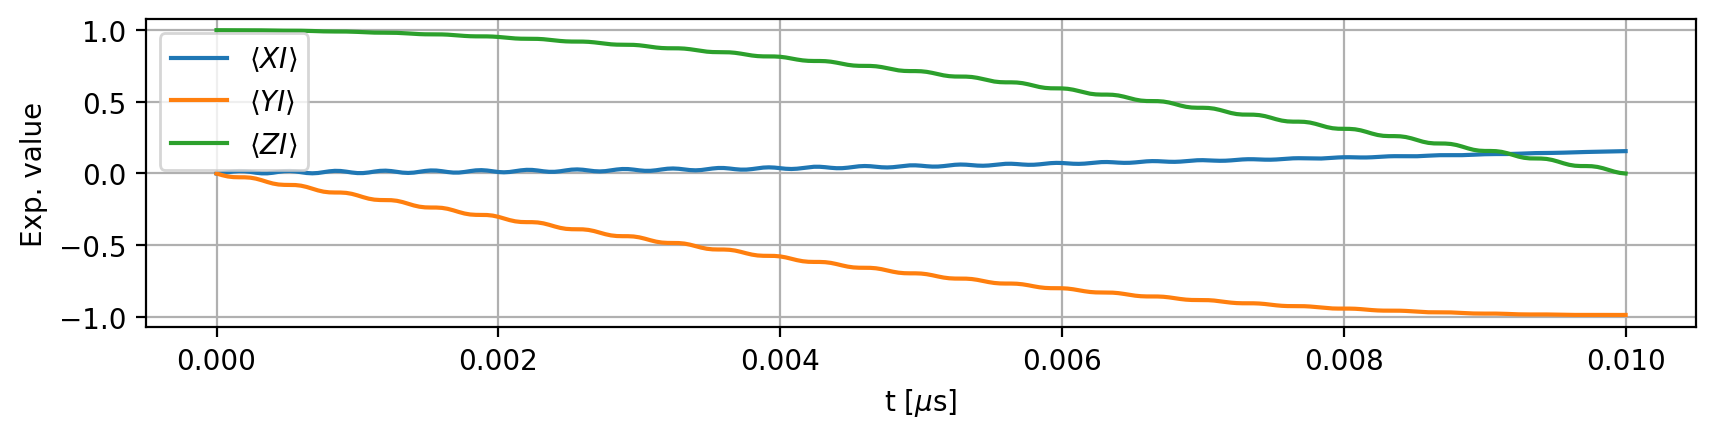

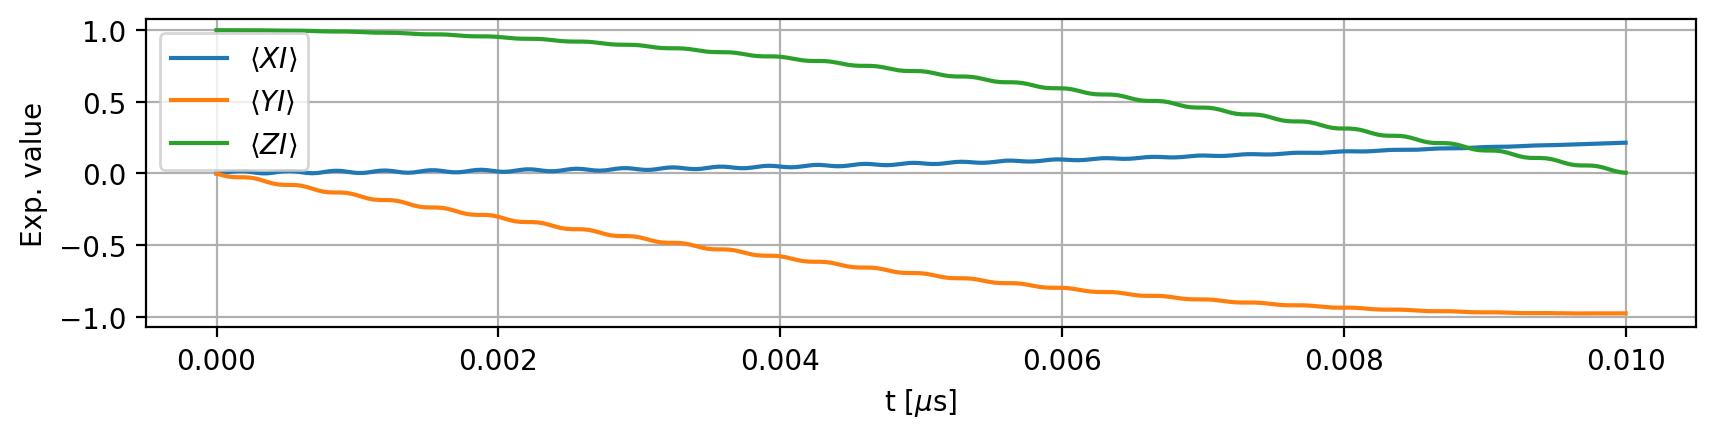

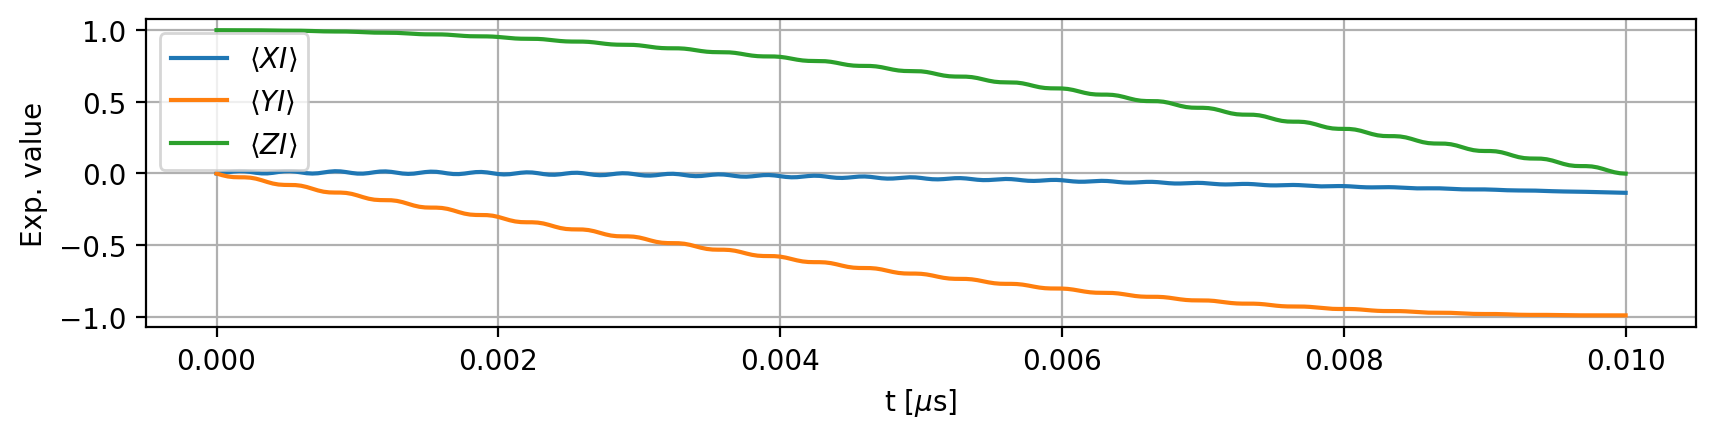

In [12]:
for i in range(3):
    result_noisy.plot_expectation_value(['XI', 'YI', 'ZI'], shot=i)

The expectation values for individual shots may vary slightly compared to the ideal case. Below, we also plot the average:

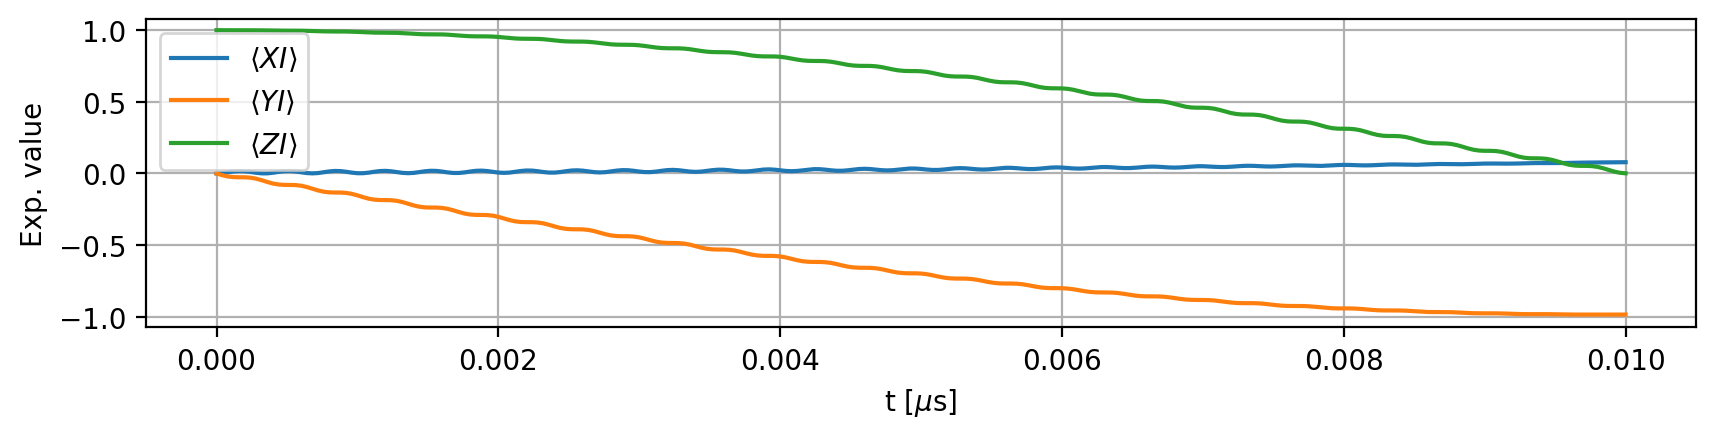

In [13]:
result_noisy.plot_expectation_value(['XI', 'YI', 'ZI'], shot='avg')

If we want to calculate or plot the process matrix, `shot` could be `'avg'` or a specific shot indicated by an integer:

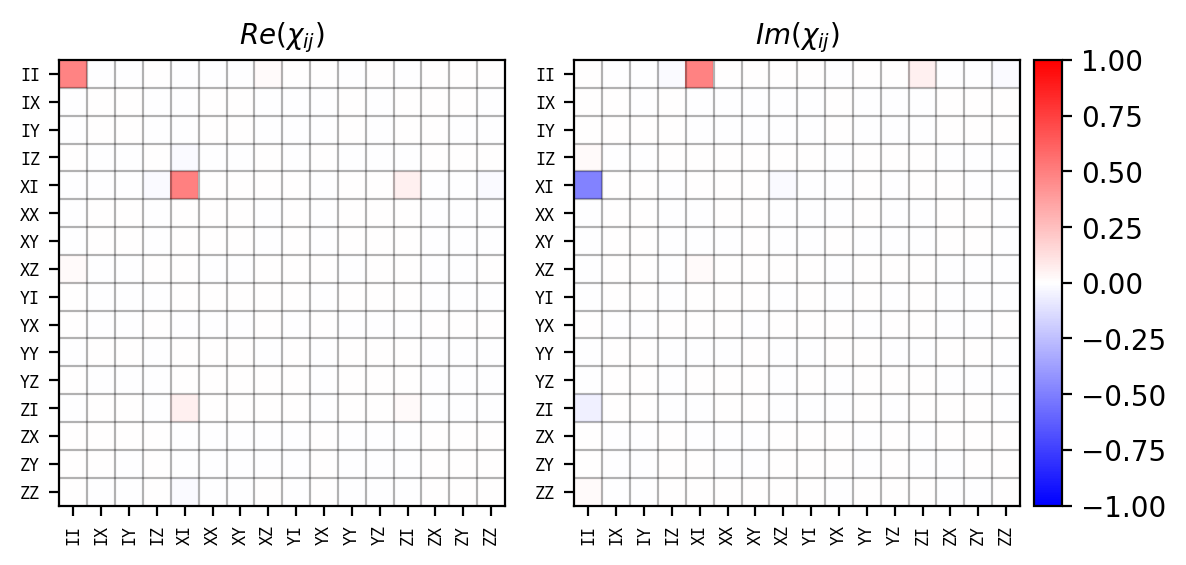

In [14]:
result_noisy.plot_process_matrix(value='re-im', shot='avg')

The ideal gate defined above can be used to calculate the average gate fidelity. As expected, the presence of noise reduces the gate fidelity:

In [15]:
result_noisy.ideal = qc
result_noisy.average_gate_fidelity()

np.float64(0.9836799252125421)

## Ramsey experiment

First of all, we set a realistic value for the noise strength associated with the electron spin:

In [16]:
model.spin('e').local_quasistatic_noise.z = 0.1 # MHz

Here, we simulate a **Ramsey interferometry experiment**. The first operation is a **$\pi/2$ pulse** that prepares the qubit (electon spin) in a superposition state. After a **free evolution** period of duration `wait`, during which the qubit accumulates a phase, a **second $\pi/2$ pulse**—with a phase difference of $\pi$—is applied to rotate the electron back to its original state. We implement this using the following function:

In [17]:
def Ramsey(model, wait, apply_noise=False, n_shots=1):
    
    duration = 0.01
    
    frequency = model.splitting_qubit('e', rest_quantum_nums={'N': 0})
    
    angle = np.pi / 2
    period_time = 2 * np.pi * duration / angle 
    amplitude = model.rabi_cycle_amplitude_qubit(driving_field_name='MW_x',
                                                 period_time=period_time,
                                                 spin_name='e')
    
    model.remove_all_pulses()
    model.driving_field('MW_x').add_rectangle_pulse(amplitude=amplitude,
                                                    frequency=frequency,
                                                    phase=0,
                                                    duration=duration)    
    model.driving_field('MW_x').add_wait(wait)
    model.driving_field('MW_x').add_rectangle_pulse(amplitude=amplitude,
                                                    frequency=frequency,
                                                    phase=np.pi,
                                                    duration=duration)

    result = model.simulate_time_evolution(n_eval=2, apply_noise=apply_noise, n_shots=n_shots)
    
    result.initial_state = model.productstate({'e': 0, 'N': 0})
    expectation_value = result.expectation_value('ZI', t_idx=-1, shot='all', frame='lab')
    
    return expectation_value[:,0,0]

The function **return the expextation value of the $Z$ operator** ($\langle ZI\rangle$) definied in the qubit subspace of the electron spin as an array for the diffrent shots. Note that the initial state is assumed to have both the electron and nuclear spins in state `0`.

Run a simulation:

In [18]:
Ramsey(model=model, wait=1)

array([0.9998])

Run the function again:

In [19]:
Ramsey(model=model, wait=1)

array([0.9998])

Thanks to Just-In-Time (JIT) compilation, the second execution runs **dramatically faster**, expecially on GPU, reducing the runtime from $\approx 10~\text{s}$ to just $150~\text{ms}$—an improvement of more than $50\times$. Notably, this acceleration persists even when simulating multiple noise realizations.

Below is a plot of the Ramsey pulse sequence:


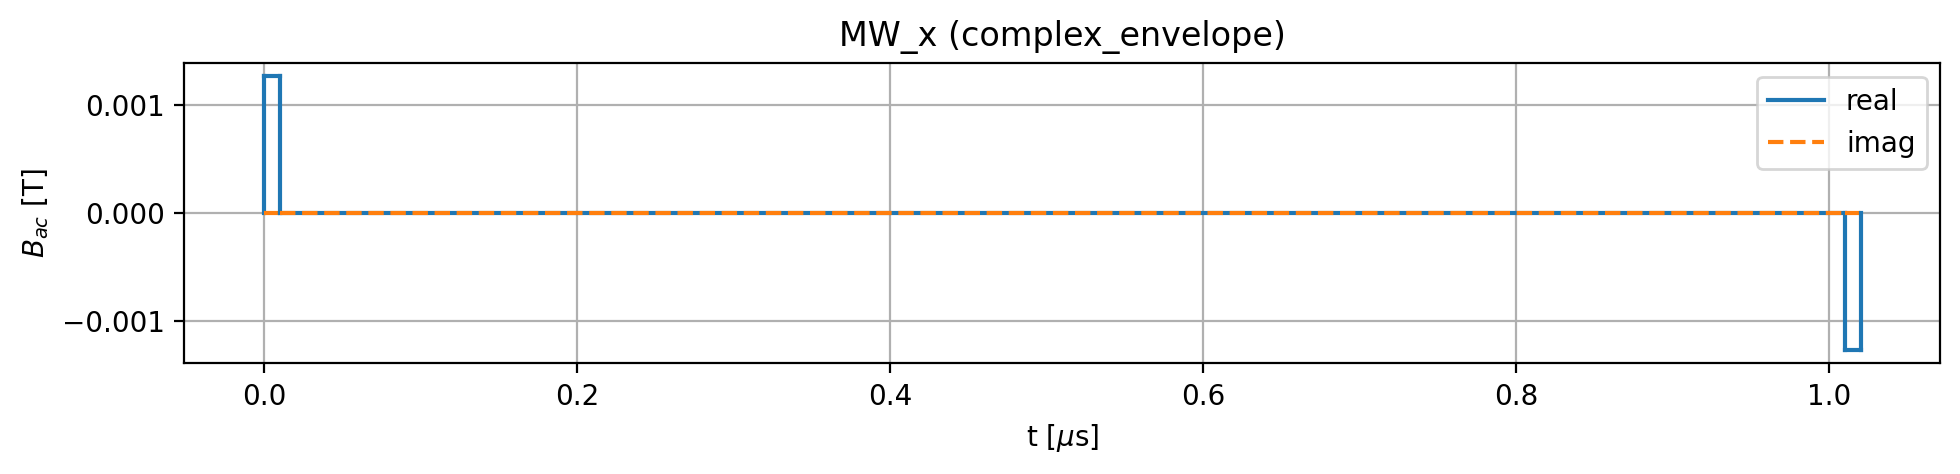

In [20]:
model.driving_field('MW_x').plot_pulses(function='complex_envelope')

To validate the ``Ramsey`` function, we evaluate it for a range of waiting times and plot the resulting expectation values:

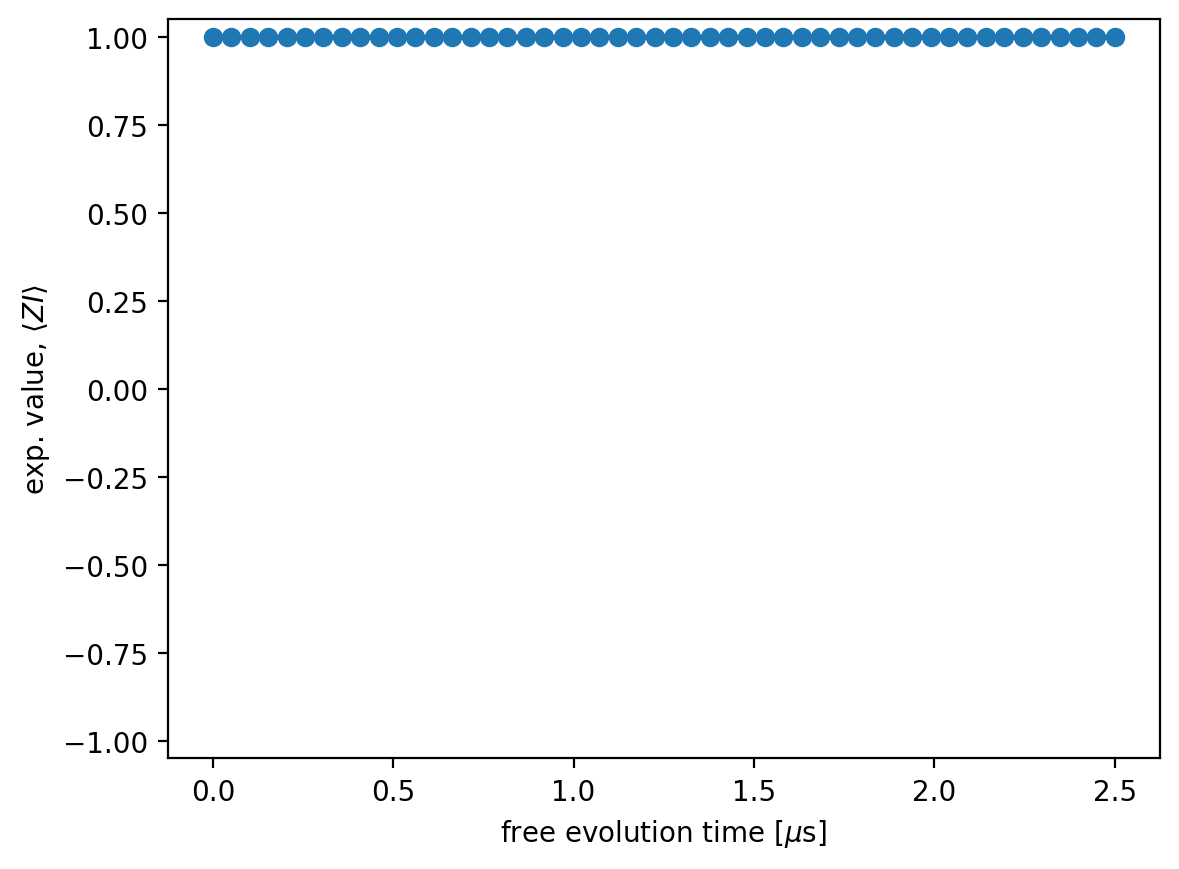

In [21]:
waits = np.linspace(1e-5, 2.5, 50)
Z_exps = []
for wait in waits:
    Z_exp = Ramsey(model=model, wait=wait)
    Z_exps.append(Z_exp)
Z_exps = np.array(Z_exps)

plt.plot(waits, Z_exps, 'o-')
plt.xlabel('free evolution time [$\mu$s]')
plt.ylabel('exp. value, $\\langle ZI \\rangle$')
plt.ylim(-1.05,1.05)
plt.show()

In the absence of noise, we get $\langle ZI \rangle = 1$ for all free evolution times.

Repeat the **simulation in the presence of noise**. We simulate $512$ shots for $8$ different free evolution times. With this number of shots, the simulation may take more than $15$ minutes to complete:

In [22]:
waits = np.linspace(1e-5, 6, 7)
n_shots = 512
Z_exps = []
for idx, wait in enumerate(waits):
    Z_exp = Ramsey(model=model, wait=wait, apply_noise=True, n_shots=n_shots)
    Z_exps.append(Z_exp)
    print(f'{idx+1}/{len(waits)}', end=' ')
Z_exps = np.array(Z_exps)

1/7 2/7 3/7 4/7 5/7 6/7 7/7 

We plot the expectation value averaged over shots, together with its $95\%$ confidence interval computed using the bootstrap method. The result shows a **Gaussian-shaped dephasing curve**:

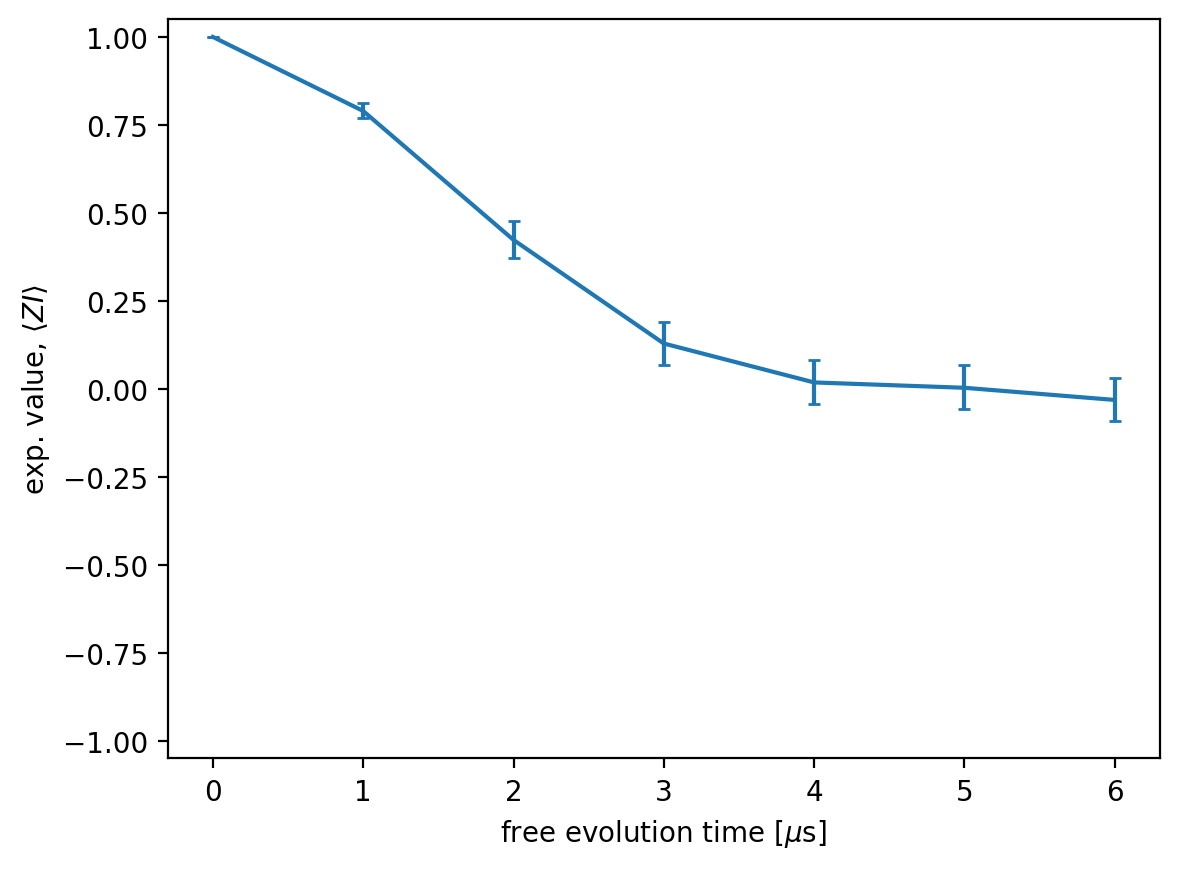

In [23]:
Z_exps_bootstaped = bootstrap((Z_exps,), lambda x, axis: np.mean(x, axis=axis), vectorized=True, axis=1)

Z_exps_mean = np.mean(Z_exps, axis=1)
Z_exps_low = Z_exps_bootstaped.confidence_interval.low
Z_exps_high = Z_exps_bootstaped.confidence_interval.high
Z_exps_err = [Z_exps_high - Z_exps_mean, Z_exps_mean - Z_exps_low]

plt.errorbar(waits, Z_exps_mean, yerr=Z_exps_err, capsize=2)
plt.xlabel('free evolution time [$\mu$s]')
plt.ylabel('exp. value, $\\langle ZI \\rangle$')
plt.ylim(-1.05,1.05)
plt.show()

Finally, we fit the data to the **theoretical model**:

$$
\langle ZI \rangle = \exp\!\big[-(\tau / T_2^*)^2\big],
$$

where $\tau$ is the free evolution time and $T_2^*$ is the inhomogeneous dephasing time. We then plot the fitted curve together with the simulated data:

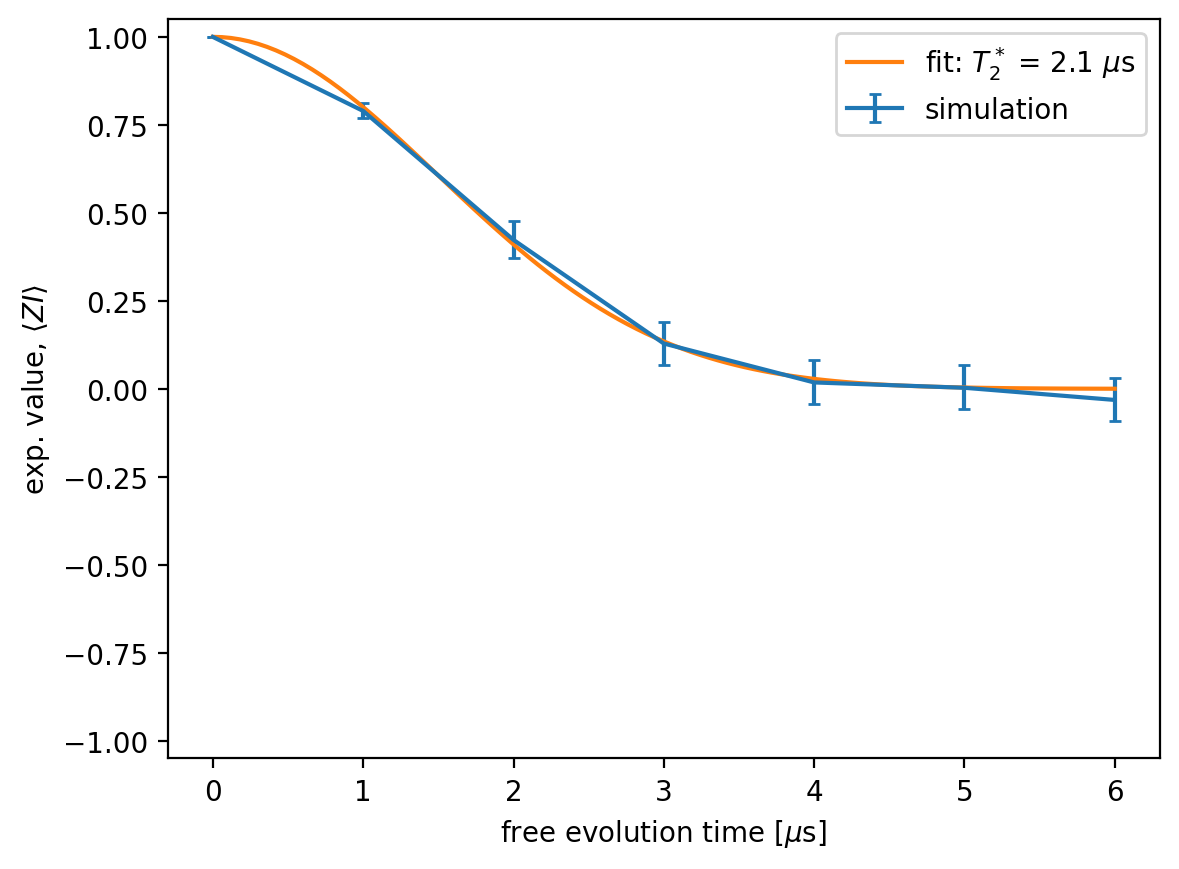

In [24]:
def func(tau, t2s):
    return np.exp(- tau**2 / t2s**2)

popt, pcov = curve_fit(func, waits, Z_exps_mean)
waits2 = np.linspace(waits[0], waits[-1], 101)
Z_exps_mean_fit = [func(t, *popt) for t in waits2]

plt.errorbar(waits, Z_exps_mean, yerr=Z_exps_err, capsize=2, label='simulation')
plt.plot(waits2, Z_exps_mean_fit, label=f'fit: $T_2^*$ = {popt[0]:.2g} $\mu$s')
plt.xlabel('free evolution time [$\mu$s]')
plt.ylabel('exp. value, $\\langle ZI \\rangle$')
plt.ylim(-1.05,1.05)
plt.legend()
plt.show()